<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_10/Supp_Fig_10e/2_check_detection_of_RdRP_seqs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check if all original PalmDB RdRP sequences can be detected when using the sequences clustered with MMseqs2 as reference index

In [ ]:
!pip install -q biopython kb_python
import pandas as pd
from Bio import SeqIO
import kb_python.utils as kb_utils

In [ ]:
# Install kallisto from source
!git clone -q https://github.com/pachterlab/kallisto.git
!cd kallisto && mkdir build && cd build && cmake .. && make

# Install bustools from source
!git clone -q https://github.com/BUStools/bustools.git
!cd bustools && mkdir build && cd build && cmake .. && make

# Define paths to kallisto and bustools binaries
kallisto = "/content/kallisto/build/src/kallisto"
bustools = "/content/bustools/build/src/bustools"

Download the original PalmDB file containing amino acid RdRP sequences as provided by Edgar et al. The file was originally downloaded from here: https://github.com/rcedgar/palmdb/blob/main/2021-03-14/uniques.fa.gz

In [ ]:
!wget https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/create_optimized_palmdb/uniques.fa
palmdb = "uniques.fa"

Download PalmDB RdRP sequences reverse translated to nucleotides as shown in [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_3/Figure_3b/validate_palmdb2palmdb.ipynb):

In [ ]:
!wget https://github.com/pachterlab/LSCHWCP_2023/raw/main/Notebooks/Figure_3/Figure_3b/palmdb_rdrp_seqs_nucleotides.fasta.zip
!unzip palmdb_rdrp_seqs_nucleotides.fasta.zip
palmdb_nn_fasta = "palmdb_rdrp_seqs_nucleotides.fasta"

Download file created in [the previous MMseqs2 notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_10/Supp_Fig_10e/1_cluster_palmdb_seqs.ipynb):

In [ ]:
# Virus IDs representing the clustered sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_10/Supp_Fig_10e/palmdb_DB_clu.tsv
rep_ids = "palmdb_DB_clu.tsv"

In [ ]:
# Files generated in this notebook
palmdb_mmseqs_nn = "uniques_mmseqs_nn.fasta"
virus_t2g = "cfc_PalmDBclu_t2g.txt"

virus_index = "virus_index.idx"
out_folder = "testing"
sample = "palmdb_vs_palmdb"

___

### Create fasta file containing amino acid sequences from representative sequence IDs obtained by MMseqs2 clustering in the comma-free space:

In [ ]:
mmseqs_reps = pd.read_csv(rep_ids, sep="\t", header=None)
mmseqs_reps

,0,1
0,u114232,u114232
1,u114328,u114328
2,u114328,u246949
3,u114328,u33194
4,u114328,u289771
...,...,...
296618,u32986,u32986
296619,u33626,u33626
296620,u33690,u33690
296621,u33690,u32713


In [ ]:
%%time
rep_seqs =  mmseqs_reps[0].unique()
with open(palmdb_mmseqs_nn, "w") as palmdb_clu, open(virus_t2g, "w") as palmdb_t2g:
    for record in SeqIO.parse(palmdb, "fasta"):
        if record.id in rep_seqs:
            palmdb_clu.write(">" + record.id + "\n")
            palmdb_clu.write(str(record.seq) + "\n")

            palmdb_t2g.write(record.id + "\t" + record.id + "\n")

CPU times: user 1h 18s, sys: 7min 3s, total: 1h 7min 22s
Wall time: 1h 7min 21s


___

### Generate reference index using representative amino acid sequences

In [ ]:
threads = 2

In [ ]:
# Generate virus reference index
!$kallisto index \
    -t $threads \
    --aa \
    -i $virus_index \
    $palmdb_mmseqs_nn


[build] loading fasta file /home/laura/projects/virus-watch-data/virus_ref/mmseqs_nn/uniques_mmseqs_nn.fasta
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 4706171
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 1129096
CompactedDBG::filter(): Processed 4963482 k-mers in 15251 reads
CompactedDBG::filter(): Found 4694671 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 32173
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 73941 

### Align the reverse translated RdRP sequences to the new index containing only representative sequences:

In [ ]:
# Align
!$kallisto bus \
        -i $virus_index \
        -o $out_folder/$sample \
        --aa \
        -t $threads \
        $palmdb_nn_fasta

# Sort bus file
!$bustools sort -o $out_folder/$sample/output_sorted.bus $out_folder/$sample/output.bus

# Generate count matrix
!$bustools count \
    --genecounts \
    --cm -m \
    -o $out_folder/$sample/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/$sample/matrix.ec \
    -t $out_folder/$sample/transcripts.txt \
    $out_folder/$sample/output_sorted.bus

 all fits in buffer
Read in 73979 BUS records
reading time 0s
sorting time 0.01s
writing time 0s


In [ ]:
# Load count matrix
# Filepath to counts
X = f"{out_folder}/{sample}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/{sample}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/{sample}/bustools_count/output.barcodes.txt"

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:652: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 1 × 15251

In [ ]:
# Load number of expected matches per representative sequence
rep_id_df = pd.read_csv(rep_ids, sep="\t", header=None)
rep_id_df

,0,1
0,u114232,u114232
1,u114328,u114328
2,u114328,u246949
3,u114328,u33194
4,u114328,u289771
...,...,...
296618,u32986,u32986
296619,u33626,u33626
296620,u33690,u33690
296621,u33690,u32713


In [ ]:
%%time
# Get expected and observed counts for each virus ID
counts = []
expected_counts = []
for virus_id in adata.var.index:
    counts.append(adata[:, adata.var.index==virus_id].X.sum())
    expected_counts.append(len(rep_id_df[rep_id_df[0]==virus_id]))

CPU times: user 3min 41s, sys: 47.7 ms, total: 3min 41s
Wall time: 3min 41s


Plot expected over obeserved counts for each virus ID:

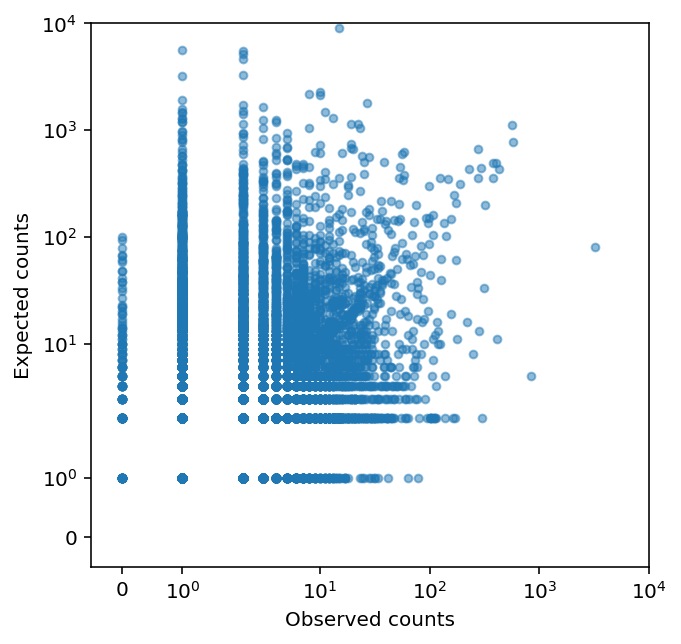

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(counts, expected_counts, s=15, alpha=0.5)
ax.set_xlabel("Observed counts")
ax.set_ylabel("Expected counts")

ax.set_xscale("symlog")
ax.set_yscale("symlog")

ax.set_ylim(bottom=-0.5, top=10000)
ax.set_xlim(left=-0.5, right=10000)

plt.savefig(f"figures/1.2_{sample}.png", dpi=300, bbox_inches="tight")

fig.show()

A lot of sequences are not aligned anymore when the RdRP sequences are clustered prior to making the index.